In [1]:
# !pip install psycopg2-binary

# Data Ingestion and Prep

There are many ways to ingest data into the Iguazio platform. There are a full series of tutorials on different connection methods and data sources at this GitHub repo: https://github.com/v3io/tutorials/tree/master.

This demo will showcase a subset of these capabilites and how they can integrate with the feature store:
- Ingest from External DB (PostgreSQL)
- Ingest from S3 (CSV)
- Ingest from Local File (Parquet)

We will be ingesting from these different sources, but using a combination of these different data sources/sets to train our ML model. This will simulate utilizing different data sources/sets to for feature engineering and creating a comprehensive data set for some purpose (in our case, training a model).

*Note: Ingesting into the feature store is not strictly necessary - it is absolutely possible to ingest directly into your application/job/pipeline. However, using the feature store allows for custom real-time data ingestion pipelines, statistical information on features, real-time joins between different data sources, and more.*

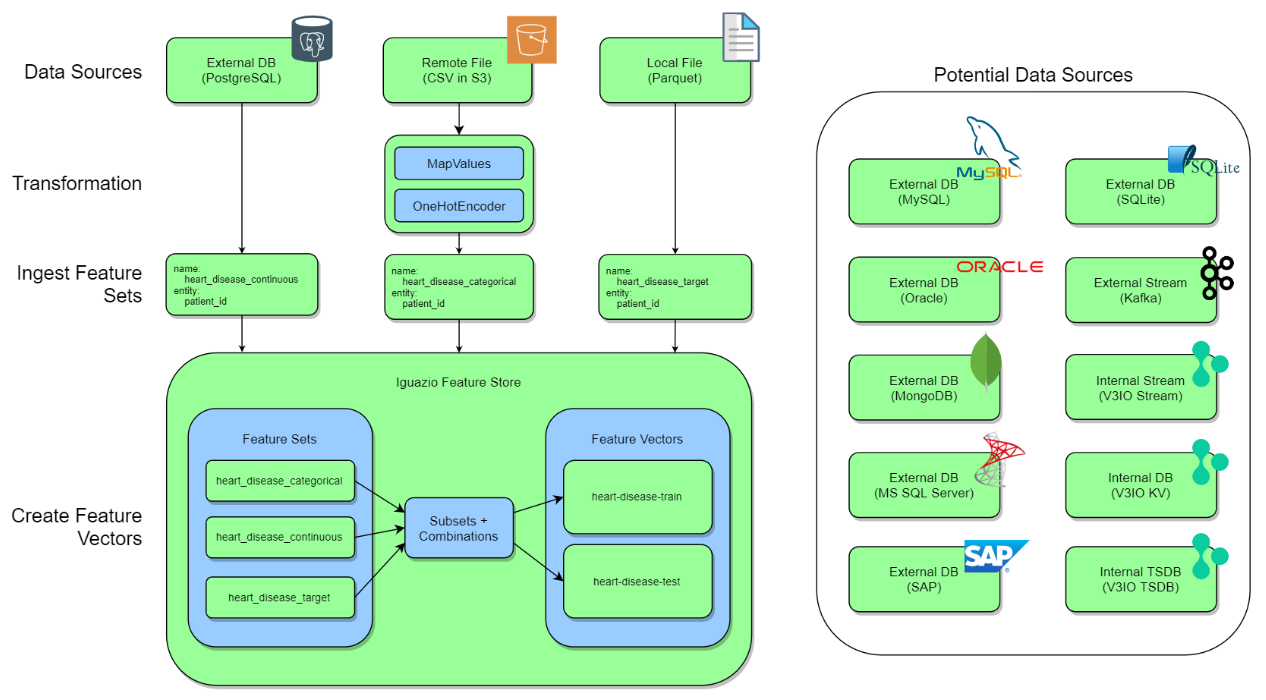

In [2]:
from IPython.display import Image
Image(filename='img/feature_store_diagram_2.png') 

### Set up MLRun Environment

In [3]:
from mlrun import set_environment
import mlrun.feature_store as fs
from mlrun.feature_store.steps import *
import pandas as pd
import os
import yaml

# Load config
with open("config.yaml") as f:
    config = yaml.safe_load(f)

# Set the default environment configuration
project_name_base = "level-3-demo"
project_name, artifact_path = set_environment(project=project_name_base,
                                              artifact_path="/User/artifacts/{{run.project}}/{{workflow.uid}}")

# Data directory
data_path = "data"

# AWS credentials
os.environ["AWS_ACCESS_KEY_ID"] = config["AWS_ACCESS_KEY_ID"]
os.environ["AWS_SECRET_ACCESS_KEY"] = config["AWS_SECRET_ACCESS_KEY"]
os.environ["AWS_DEFAULT_REGION"] = config["AWS_DEFAULT_REGION"]

### Ingest from Local File (Parquet)

In [4]:
pd.read_parquet(f"{data_path}/heart_disease_target.parquet").head()

,patient_id,target
0,e443544b-8d9e-4f6c-9623-e24b6139aae0,0
1,8227d3df-16ab-4452-8ea5-99472362d982,0
2,10c4b4ba-ab40-44de-8aba-6bdb062192c4,0
3,f0acdc22-7ee6-4817-a671-e136211bc0a6,0
4,2d6b3bca-4841-4618-9a8c-ca902010b009,0


In [5]:
heart_disease_target_set = fs.FeatureSet("heart_disease_target", entities=[fs.Entity("patient_id")])
heart_disease_target_set.set_targets()

resp = fs.ingest(featureset=heart_disease_target_set,
                 source=f"{data_path}/heart_disease_target.parquet",
                 infer_options=fs.InferOptions.default())

### Ingest from External DB (PostgreSQL)

In [6]:
import psycopg2
from sqlalchemy.engine import create_engine
    
engine = create_engine(config["POSTGRESQL_DB"])

# Read entire table
postgresql_df = pd.read_sql('select * from heart_disease_continuous', engine)

# Read table in batches
# postgresql_iterator = pd.read_sql('select * from heart_disease_continuous', engine, chunksize=100)

postgresql_df.head()

,patient_id,trestbps,chol,restecg,thalach,oldpeak,ca
0,e443544b-8d9e-4f6c-9623-e24b6139aae0,125,212,1,168,1.0,2.0
1,8227d3df-16ab-4452-8ea5-99472362d982,140,203,0,155,3.1,0.0
2,10c4b4ba-ab40-44de-8aba-6bdb062192c4,145,174,1,125,2.6,0.0
3,f0acdc22-7ee6-4817-a671-e136211bc0a6,148,203,1,161,0.0,1.0
4,2d6b3bca-4841-4618-9a8c-ca902010b009,138,294,1,106,1.9,3.0


In [7]:
heart_disease_continuous_set = fs.FeatureSet("heart_disease_continuous", entities=[fs.Entity("patient_id")])
heart_disease_continuous_set.set_targets()

resp = fs.ingest(featureset=heart_disease_continuous_set,
                 source=postgresql_df,
                 infer_options=fs.InferOptions.default())

### Ingest from S3 (CSV)

In [8]:
# Local copy - will actually be reading from S3
pd.read_csv(f"{data_path}/heart_disease_categorical.csv").head()

,patient_id,age,sex,cp,exang,fbs,slope,thal
0,e443544b-8d9e-4f6c-9623-e24b6139aae0,52,male,typical_angina,no,False,downsloping,normal
1,8227d3df-16ab-4452-8ea5-99472362d982,53,male,typical_angina,yes,True,upsloping,normal
2,10c4b4ba-ab40-44de-8aba-6bdb062192c4,70,male,typical_angina,yes,False,upsloping,normal
3,f0acdc22-7ee6-4817-a671-e136211bc0a6,61,male,typical_angina,no,False,downsloping,normal
4,2d6b3bca-4841-4618-9a8c-ca902010b009,62,female,typical_angina,no,True,flat,reversable_defect


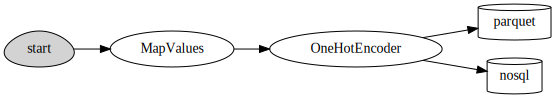

In [9]:
heart_disease_categorical = fs.FeatureSet("heart_disease_categorical", entities=[fs.Entity("patient_id")])
heart_disease_categorical.set_targets()
graph = heart_disease_categorical.spec.graph

age_mapping = {'age': {'ranges': [{'range': [0, 3], "value": "toddler"},
                                  {'range': [3, 18], "value": "child"},
                                  {'range': [18, 65], "value": "adult"},
                                  {'range': [65, 120], "value": "elder"}]}}

one_hot_encoder_mapping = {'age_mapped': ['toddler', 'child', 'adult', 'elder'],
                           'sex': ['male', 'female'],
                           'cp': ['typical_angina', 'atypical_angina', 'non_anginal_pain', 'asymtomatic'],
                           'exang': ['no', 'yes'],
                           'fbs': [False, True],
                           'slope': ['downsloping', 'upsloping', 'flat'],
                           'thal': ['normal', 'reversable_defect', 'fixed_defect']}

graph.to(MapValues(mapping=age_mapping, with_original_features=True))\
     .to(OneHotEncoder(mapping=one_hot_encoder_mapping))

heart_disease_categorical.plot(rankdir='LR', with_targets=True)

In [10]:
resp = fs.ingest(featureset=heart_disease_categorical,
                 source="s3://igz-us-sales/heart/heart_disease_categorical.csv",
                 infer_options=fs.InferOptions.default())

In [11]:
# Upload transformed data back to S3 - requires s3fs libary
resp.to_csv("s3://igz-us-sales/heart/heart_ingested.csv")

### Example Feature Vector

In [12]:
# features = ["heart_disease_categorical.age_mapped_toddler",
#             "heart_disease_categorical.age_mapped_child",
#             "heart_disease_categorical.age_mapped_adult",
#             "heart_disease_categorical.age_mapped_elder"]

features = ["heart_disease_categorical.*",
            "heart_disease_continuous.*"]
vector = fs.FeatureVector("heart-disease-train", features)

In [13]:
resp = fs.get_offline_features(vector)
df = resp.to_dataframe()
df.head()

,age_mapped_toddler,age_mapped_child,age_mapped_adult,age_mapped_elder,age,sex_male,sex_female,cp_typical_angina,cp_atypical_angina,cp_non_anginal_pain,...,slope_flat,thal_normal,thal_reversable_defect,thal_fixed_defect,trestbps,chol,restecg,thalach,oldpeak,ca
patient_id,,,,,,,,,,,,,,,,,,,,,
e443544b-8d9e-4f6c-9623-e24b6139aae0,0,0,1,0,52,1,0,1,0,0,...,0,1,0,0,125,212,1,168,1.0,2.0
8227d3df-16ab-4452-8ea5-99472362d982,0,0,1,0,53,1,0,1,0,0,...,0,1,0,0,140,203,0,155,3.1,0.0
10c4b4ba-ab40-44de-8aba-6bdb062192c4,0,0,0,1,70,1,0,1,0,0,...,0,1,0,0,145,174,1,125,2.6,0.0
f0acdc22-7ee6-4817-a671-e136211bc0a6,0,0,1,0,61,1,0,1,0,0,...,0,1,0,0,148,203,1,161,0.0,1.0
2d6b3bca-4841-4618-9a8c-ca902010b009,0,0,1,0,62,0,1,1,0,0,...,1,0,1,0,138,294,1,106,1.9,3.0


In [14]:
features = ["heart_disease_target.*"]
vector = fs.FeatureVector("heart-disease-test", features)
resp = fs.get_offline_features(vector)

In [15]:
resp = fs.get_offline_features(vector)
df = resp.to_dataframe()
df.head()

,target
patient_id,
e443544b-8d9e-4f6c-9623-e24b6139aae0,0
8227d3df-16ab-4452-8ea5-99472362d982,0
10c4b4ba-ab40-44de-8aba-6bdb062192c4,0
f0acdc22-7ee6-4817-a671-e136211bc0a6,0
2d6b3bca-4841-4618-9a8c-ca902010b009,0


### Use Feature Vector During Offline Training

In [16]:
fs.get_offline_features("level-3-demo/heart-disease-train").to_dataframe().head()

,age_mapped_toddler,age_mapped_child,age_mapped_adult,age_mapped_elder,age,sex_male,sex_female,cp_typical_angina,cp_atypical_angina,cp_non_anginal_pain,...,slope_flat,thal_normal,thal_reversable_defect,thal_fixed_defect,trestbps,chol,restecg,thalach,oldpeak,ca
patient_id,,,,,,,,,,,,,,,,,,,,,
e443544b-8d9e-4f6c-9623-e24b6139aae0,0,0,1,0,52,1,0,1,0,0,...,0,1,0,0,125,212,1,168,1.0,2.0
8227d3df-16ab-4452-8ea5-99472362d982,0,0,1,0,53,1,0,1,0,0,...,0,1,0,0,140,203,0,155,3.1,0.0
10c4b4ba-ab40-44de-8aba-6bdb062192c4,0,0,0,1,70,1,0,1,0,0,...,0,1,0,0,145,174,1,125,2.6,0.0
f0acdc22-7ee6-4817-a671-e136211bc0a6,0,0,1,0,61,1,0,1,0,0,...,0,1,0,0,148,203,1,161,0.0,1.0
2d6b3bca-4841-4618-9a8c-ca902010b009,0,0,1,0,62,0,1,1,0,0,...,1,0,1,0,138,294,1,106,1.9,3.0


### Online Feature Vector for Real-Time Inference

In [17]:
feature_service = fs.get_online_feature_service("level-3-demo/heart-disease-train")

In [18]:
feature_service.vector.uri

'store://feature-vectors/level-3-demo/heart-disease-train:latest'

In [19]:
# Use statistical data on features for imputing and outlier detection during inference
feature_service.vector.get_stats_table()

,count,mean,std,min,max,hist
age_mapped_toddler,968.0,0.000000,0.000000,0.0,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 968, 0, 0, 0, ..."
age_mapped_child,968.0,0.000000,0.000000,0.0,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 968, 0, 0, 0, ..."
age_mapped_adult,968.0,0.875000,0.330890,0.0,1.0,"[[121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
age_mapped_elder,968.0,0.125000,0.330890,0.0,1.0,"[[847, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
age,968.0,54.073347,9.127036,29.0,77.0,"[[4, 0, 21, 18, 25, 84, 61, 64, 38, 79, 98, 89..."
sex_male,968.0,0.715909,0.451213,0.0,1.0,"[[275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
sex_female,968.0,0.284091,0.451213,0.0,1.0,"[[693, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
cp_typical_angina,968.0,0.473140,0.499536,0.0,1.0,"[[510, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
cp_atypical_angina,968.0,0.169421,0.375318,0.0,1.0,"[[804, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
cp_non_anginal_pain,968.0,0.280992,0.449716,0.0,1.0,"[[696, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [20]:
feature_service.get([{"patient_id" : "e443544b-8d9e-4f6c-9623-e24b6139aae0"},
                     {"patient_id" : "8227d3df-16ab-4452-8ea5-99472362d982"}])

[{'age_mapped_toddler': 0,
  'age_mapped_child': 0,
  'age_mapped_adult': 1,
  'age_mapped_elder': 0,
  'age': 52,
  'sex_male': 1,
  'sex_female': 0,
  'cp_typical_angina': 1,
  'cp_atypical_angina': 0,
  'cp_non_anginal_pain': 0,
  'cp_asymtomatic': 0,
  'exang_no': 1,
  'exang_yes': 0,
  'fbs_False': 1,
  'fbs_True': 0,
  'slope_downsloping': 1,
  'slope_upsloping': 0,
  'slope_flat': 0,
  'thal_normal': 1,
  'thal_reversable_defect': 0,
  'thal_fixed_defect': 0,
  'trestbps': 125,
  'chol': 212,
  'restecg': 1,
  'thalach': 168,
  'oldpeak': 1.0,
  'ca': 2.0},
 {'age_mapped_toddler': 0,
  'age_mapped_child': 0,
  'age_mapped_adult': 1,
  'age_mapped_elder': 0,
  'age': 53,
  'sex_male': 1,
  'sex_female': 0,
  'cp_typical_angina': 1,
  'cp_atypical_angina': 0,
  'cp_non_anginal_pain': 0,
  'cp_asymtomatic': 0,
  'exang_no': 0,
  'exang_yes': 1,
  'fbs_False': 0,
  'fbs_True': 1,
  'slope_downsloping': 0,
  'slope_upsloping': 1,
  'slope_flat': 0,
  'thal_normal': 1,
  'thal_reversa